In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os
import pandas as pd 
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import RMSprop,Adam

Loading data

In [2]:
training_images = []
training_groundTruth = []
validation_images = []
validation_groundTruth = []
test_images = []
test_groundTruth = []

path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/train/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  training_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/train/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  training_groundTruth.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/valid/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  validation_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/valid/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  validation_groundTruth.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/test/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  test_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/test/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  test_groundTruth.append(img)

In [3]:
training_images = np.array(training_images)
training_groundTruth = np.array(training_groundTruth)
validation_images = np.array(validation_images)
validation_groundTruth = np.array(validation_groundTruth)
test_images = np.array(test_images)
test_groundTruth = np.array(test_groundTruth)
training_images.sort()
training_groundTruth.sort()
input_shape = training_images[0].shape
print(input_shape)
print(training_groundTruth.shape)

(256, 256, 3)
(2000, 256, 256, 3)


Image samples

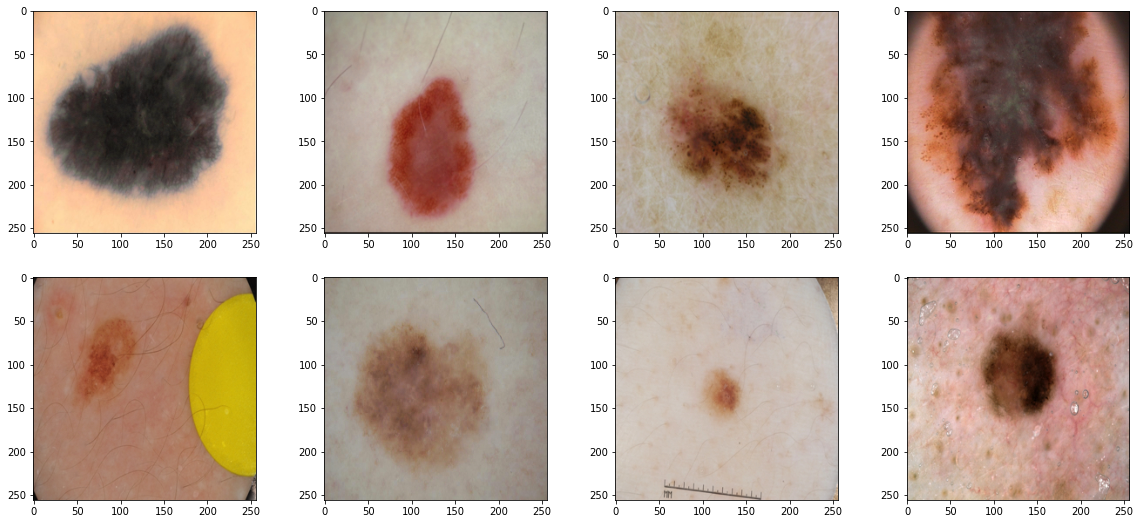

In [4]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(training_images[0], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,2)
plt.imshow(cv2.cvtColor(training_images[55], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,3)
plt.imshow(cv2.cvtColor(training_images[130], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,4)
plt.imshow(cv2.cvtColor(training_images[255], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(training_images[512], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,6)
plt.imshow(cv2.cvtColor(training_images[1024], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,7)
plt.imshow(cv2.cvtColor(training_images[1350], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,8)
plt.imshow(cv2.cvtColor(training_images[1890], cv2.COLOR_BGR2RGB))
plt.show()

Image masks

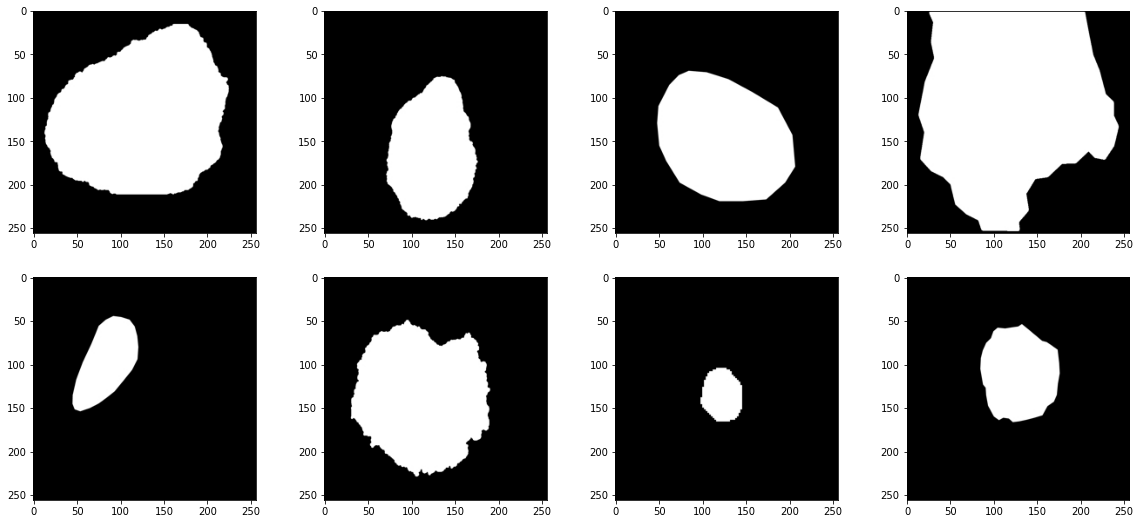

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(training_groundTruth[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(training_groundTruth[55], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(training_groundTruth[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(training_groundTruth[255], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(training_groundTruth[512], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(training_groundTruth[1024], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(training_groundTruth[1350], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(training_groundTruth[1890], cmap = plt.cm.binary_r)
plt.show()

Data augmentation

In [6]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image[0].shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)
    
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(training_images, training_groundTruth)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(validation_images, validation_groundTruth)

In [7]:
model = VGG16()
model.summary()

2022-01-10 20:54:27.059881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 20:54:27.150356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 20:54:27.151044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 20:54:27.152158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
new_input = keras.Input(shape=input_shape)
vgg = VGG16(include_top=False, input_tensor=new_input, classes=2)
output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)
vgg = Model(vgg.input, output)
for layer in vgg.layers:
   layer.trainable = False
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [9]:
model = Sequential()
model.add(vgg)
model.add(Conv2D(filters=512, kernel_size=(1,1),activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1),activation="relu"))
model.add(Conv2D(filters=2, kernel_size=(1,1),activation="relu"))
# model.add(layer = tf.keras.layers.Dropout(.5, input_shape=(2,)))
model.add(Conv2DTranspose(filters=3, kernel_size=(1,1), strides=(32,32) ,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         262656    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         262656    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 2)           1026      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 3)       9         
Total params: 15,241,035
Trainable params: 526,347
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
from keras import backend as K

def IoU(y_true, y_pred, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    total = K.sum(y_true + y_pred)
    union = total - intersection
    IoU = (intersection + smooth)/(union + smooth)
    return  IoU

def jacc_loss(y_true, y_pred):
     return 1-IoU(y_true, y_pred)

In [11]:
model.compile(loss=[jacc_loss],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics=[IoU])

In [12]:
result = model.fit(training_images,training_groundTruth.astype(np.float32),
                    validation_data=(validation_images, validation_groundTruth.astype(np.float32)),
                    batch_size=24,
                    epochs=5,
                    verbose=1)

2022-01-10 20:54:31.548969: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-01-10 20:54:33.233924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-01-10 20:54:34.549793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-01-10 20:54:36.196039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


84/84 [==============================] - 19s 106ms/step - loss: 0.5052 - IoU: 0.4947 - val_loss: 0.5075 - val_IoU: 0.4930
Epoch 2/5
84/84 [==============================] - 7s 80ms/step - loss: 0.5052 - IoU: 0.4948 - val_loss: 0.5075 - val_IoU: 0.4930
Epoch 3/5
84/84 [==============================] - 7s 82ms/step - loss: 0.5052 - IoU: 0.4948 - val_loss: 0.5075 - val_IoU: 0.4930
Epoch 4/5
84/84 [==============================] - 7s 83ms/step - loss: 0.5052 - IoU: 0.4948 - val_loss: 0.5075 - val_IoU: 0.4930
Epoch 5/5
84/84 [==============================] - 7s 83ms/step - loss: 0.5053 - IoU: 0.4947 - val_loss: 0.5075 - val_IoU: 0.4930


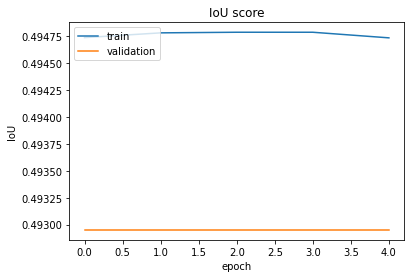

In [13]:
plt.plot(result.history['IoU'])
plt.plot(result.history['val_IoU'])
plt.title('IoU score')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()